loading and processing of the ml-latest-small dataset file, we did a join operations to merge the types of data we have gathered into one unified dataset then proceeded to handle missing values and convert types into universal type.

In [2]:
# Install required packages
!pip install pandas numpy scikit-learn nltk plotly matplotlib seaborn wordcloud streamlit -q
!pip install ipywidgets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

print("✅ All libraries imported successfully!")






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ All libraries imported successfully!


In [4]:
# Method 1: Upload directly to Colab
from google.colab import files
import io

print("📁 Please upload your 'netflix_titles.csv' file:")
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
print(f"✅ File '{filename}' uploaded successfully!")

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"📊 Dataset shape: {df.shape}")

📁 Please upload your 'netflix_titles.csv' file:


Saving netflix_titles.csv to netflix_titles.csv
✅ File 'netflix_titles.csv' uploaded successfully!
📊 Dataset shape: (8807, 12)


In [5]:
# Display basic dataset information
def explore_dataset(df):
    """Explore basic statistics and information about the dataset"""

    print("🔍 DATASET OVERVIEW")
    print("="*50)

    # Basic info
    print(f"Total records: {len(df)}")
    print(f"Total columns: {len(df.columns)}")

    # Data types and missing values
    print("\n📋 DATA TYPES & MISSING VALUES:")
    info_df = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Missing %': (df.isnull().sum() / len(df)) * 100
    })
    display(info_df)

    # Display first few rows
    print("\n👀 FIRST 5 ROWS:")
    display(df.head())

    return info_df

# Explore the dataset
info_df = explore_dataset(df)

🔍 DATASET OVERVIEW
Total records: 8807
Total columns: 12

📋 DATA TYPES & MISSING VALUES:


,Data Type,Missing Values,Missing %
show_id,object,0,0.000000
type,object,0,0.000000
title,object,0,0.000000
director,object,2634,29.908028
cast,object,825,9.367549
country,object,831,9.435676
date_added,object,10,0.113546
release_year,int64,0,0.000000
rating,object,4,0.045418
duration,object,3,0.034064



👀 FIRST 5 ROWS:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [7]:
# Focus on key columns for our recommender system
def check_key_columns(df):
    """Check the key columns we'll use for recommendations"""

    key_columns = ['title', 'description', 'listed_in', 'director', 'cast', 'type', 'release_year', 'duration']

    print("🔑 KEY COLUMNS ANALYSIS")
    print("="*50)

    for col in key_columns:
        if col in df.columns:
            print(f"\n📌 {col.upper()}:")
            print(f"   Non-null values: {df[col].notnull().sum()} ({df[col].notnull().sum()/len(df)*100:.1f}%)")
            sample_values = df[col].dropna().iloc[:3].tolist() if df[col].notnull().sum() > 0 else 'No data'
            print(f"   Sample values: {sample_values}")
        else:
            print(f"\n❌ {col} not found in dataset")

    return key_columns

key_cols = check_key_columns(df)

🔑 KEY COLUMNS ANALYSIS

📌 TITLE:
   Non-null values: 8807 (100.0%)
   Sample values: ['Dick Johnson Is Dead', 'Blood & Water', 'Ganglands']

📌 DESCRIPTION:
   Non-null values: 8807 (100.0%)
   Sample values: ['As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.', 'After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.', 'To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.']

📌 LISTED_IN:
   Non-null values: 8807 (100.0%)
   Sample values: ['Documentaries', 'International TV Shows, TV Dramas, TV Mysteries', 'Crime TV Shows, International TV Shows, TV Action & Adventure']

📌 DIRECTOR:
   Non-null values: 6173 (70.1%)
   Sample values: ['Kirsten Johnson', 'Julien Leclercq', 'Mike Flanagan']

📌 CAST:
   No

In [8]:
# Basic data cleaning function
def initial_cleaning(df):
    """Perform initial data cleaning"""

    print("🧹 STARTING DATA CLEANING...")

    # Create a copy to avoid modifying original data
    df_clean = df.copy()

    # Fill missing values for key columns
    text_columns = ['description', 'director', 'cast', 'listed_in']
    for col in text_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Unknown')
            print(f"✅ Filled missing values in {col}")

    # Remove duplicates based on title
    initial_count = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['title'], keep='first')
    final_count = len(df_clean)
    print(f"✅ Removed {initial_count - final_count} duplicate titles")

    # Filter only movies and TV shows (remove any other types if present)
    if 'type' in df_clean.columns:
        df_clean = df_clean[df_clean['type'].isin(['Movie', 'TV Show'])]
        print(f"✅ Filtered to only Movies and TV Shows: {len(df_clean)} records")

    print(f"🎯 Final dataset size: {df_clean.shape}")
    return df_clean

# Apply initial cleaning
df_clean = initial_cleaning(df)

🧹 STARTING DATA CLEANING...
✅ Filled missing values in description
✅ Filled missing values in director
✅ Filled missing values in cast
✅ Filled missing values in listed_in
✅ Removed 0 duplicate titles
✅ Filtered to only Movies and TV Shows: 8807 records
🎯 Final dataset size: (8807, 12)


📊 CREATING INITIAL VISUALIZATIONS...


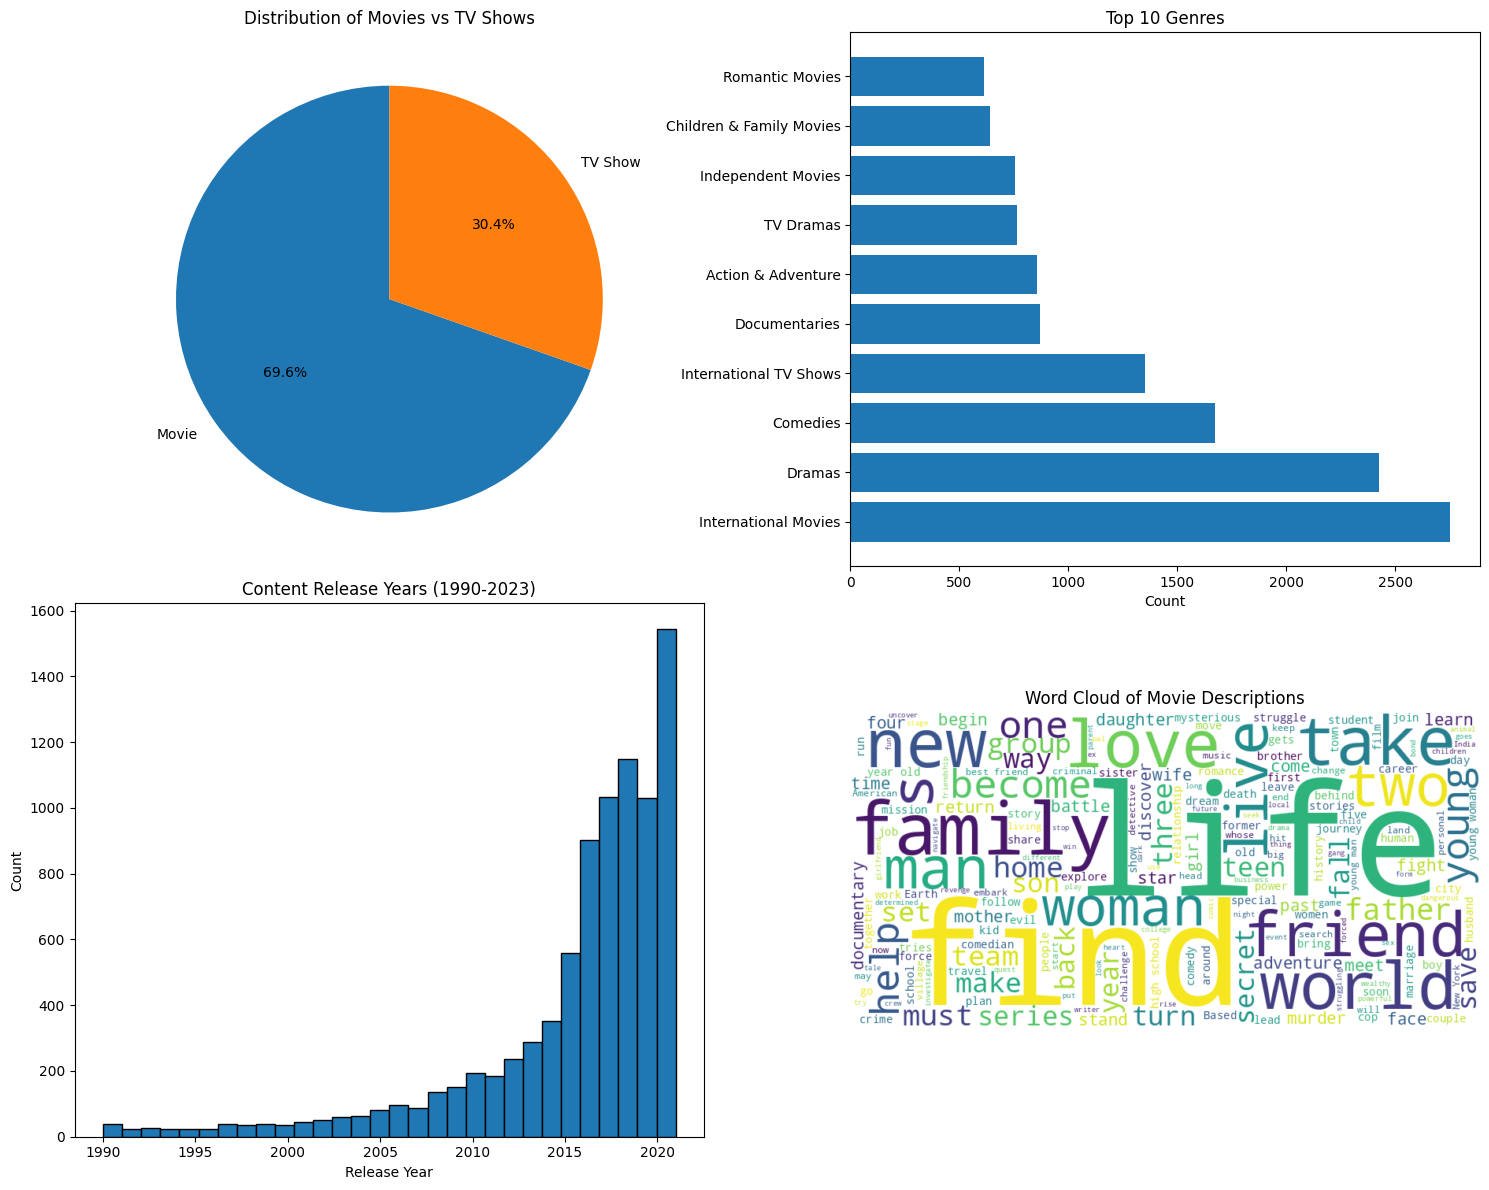

In [9]:
# Quick visualization of content distribution
def initial_visualizations(df):
    """Create initial visualizations to understand the data"""

    print("📊 CREATING INITIAL VISUALIZATIONS...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Content Type Distribution
    if 'type' in df.columns:
        type_counts = df['type'].value_counts()
        axes[0,0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
        axes[0,0].set_title('Distribution of Movies vs TV Shows')

    # 2. Top Genres
    if 'listed_in' in df.columns:
        # Extract all genres
        all_genres = []
        for genres in df['listed_in'].dropna():
            all_genres.extend([genre.strip() for genre in genres.split(',')])

        genre_counts = pd.Series(all_genres).value_counts().head(10)
        axes[0,1].barh(genre_counts.index, genre_counts.values)
        axes[0,1].set_title('Top 10 Genres')
        axes[0,1].set_xlabel('Count')

    # 3. Release Year Distribution (last 30 years)
    if 'release_year' in df.columns:
        recent_years = df[df['release_year'] >= 1990]['release_year']
        axes[1,0].hist(recent_years, bins=30, edgecolor='black')
        axes[1,0].set_title('Content Release Years (1990-2023)')
        axes[1,0].set_xlabel('Release Year')
        axes[1,0].set_ylabel('Count')

    # 4. Word Cloud of Descriptions
    if 'description' in df.columns:
        text = ' '.join(df['description'].dropna().astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        axes[1,1].imshow(wordcloud, interpolation='bilinear')
        axes[1,1].set_title('Word Cloud of Movie Descriptions')
        axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

    return fig

# Generate visualizations
initial_viz = initial_visualizations(df_clean)

In [10]:
# Create interactive visualizations
def interactive_visualizations(df):
    """Create interactive plots using Plotly"""

    print("📈 CREATING INTERACTIVE VISUALIZATIONS...")

    # 1. Content by Release Year (Interactive)
    if 'release_year' in df.columns:
        year_counts = df['release_year'].value_counts().sort_index()
        fig1 = px.line(x=year_counts.index, y=year_counts.values,
                      title='Content Releases Over Time',
                      labels={'x': 'Release Year', 'y': 'Number of Titles'})
        fig1.show()

    # 2. Top Genres (Interactive)
    if 'listed_in' in df.columns:
        all_genres = []
        for genres in df['listed_in'].dropna():
            all_genres.extend([genre.strip() for genre in genres.split(',')])

        genre_counts = pd.Series(all_genres).value_counts().head(15)
        fig2 = px.bar(x=genre_counts.values, y=genre_counts.index, orientation='h',
                     title='Top 15 Genres on Netflix',
                     labels={'x': 'Count', 'y': 'Genre'})
        fig2.show()

    # 3. Content Type by Year
    if 'type' in df.columns and 'release_year' in df.columns:
        type_year = pd.crosstab(df['release_year'], df['type'])
        fig3 = px.area(type_year, title='Movies vs TV Shows Over Time',
                      labels={'value': 'Count', 'release_year': 'Year'})
        fig3.show()

interactive_visualizations(df_clean)

📈 CREATING INTERACTIVE VISUALIZATIONS...


In [11]:
# Save the cleaned dataset to Google Drive
def save_to_drive(df, filename='netflix_cleaned.csv'):
    """Save cleaned dataset to Google Drive"""
    df.to_csv(filename, index=False)
    print(f"✅ Cleaned dataset saved as {filename}")

    # Download to local machine if desired
    files.download(filename)
    print("📥 File downloaded to your local machine!")

    return filename

# Save the cleaned data
cleaned_file = save_to_drive(df_clean)

✅ Cleaned dataset saved as netflix_cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 File downloaded to your local machine!


In [12]:
# Print summary of what we've accomplished
def project_summary(df_clean):
    """Print summary of current progress"""

    print("🎉 PHASE 1 COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"📊 Total movies/TV shows available: {len(df_clean)}")
    print(f"🎬 Movies: {len(df_clean[df_clean['type'] == 'Movie'])}")
    print(f"📺 TV Shows: {len(df_clean[df_clean['type'] == 'TV Show'])}")

    # Genre count
    all_genres = []
    for genres in df_clean['listed_in'].dropna():
        all_genres.extend([genre.strip() for genre in genres.split(',')])

    print(f"🏷️ Unique genres: {len(set(all_genres))}")
    print(f"📝 Descriptions available: {df_clean['description'].notnull().sum()}")
    print(f"🎭 Directors info available: {df_clean[df_clean['director'] != 'Unknown']['director'].count()}")
    print(f"🌟 Cast info available: {df_clean[df_clean['cast'] != 'Unknown']['cast'].count()}")

    print("\n🎯 KEY INSIGHTS:")
    print("- We have a good mix of movies and TV shows")
    print("- Genre data is comprehensive")
    print("- Descriptions are available for most content")
    print("- Ready for feature engineering!")

    print("\n➡️ NEXT STEPS: Feature Engineering and Mood Mapping")

project_summary(df_clean)

🎉 PHASE 1 COMPLETED SUCCESSFULLY!
📊 Total movies/TV shows available: 8807
🎬 Movies: 6131
📺 TV Shows: 2676
🏷️ Unique genres: 42
📝 Descriptions available: 8807
🎭 Directors info available: 6173
🌟 Cast info available: 7982

🎯 KEY INSIGHTS:
- We have a good mix of movies and TV shows
- Genre data is comprehensive
- Descriptions are available for most content
- Ready for feature engineering!

➡️ NEXT STEPS: Feature Engineering and Mood Mapping


Feature Engineering and Mood Mapping

In [13]:
# Display a random sample of movies to understand the content
print("🎲 RANDOM SAMPLE OF MOVIES:")
sample_movies = df_clean[df_clean['type'] == 'Movie'].sample(5)[['title', 'listed_in', 'description']]
for idx, row in sample_movies.iterrows():
    print(f"\n🎬 {row['title']}")
    print(f"   🏷️  Genres: {row['listed_in']}")
    print(f"   📝 Description: {row['description'][:100]}...")

🎲 RANDOM SAMPLE OF MOVIES:

🎬 Niyazi Gül Dörtnala
   🏷️  Genres: Comedies, International Movies
   📝 Description: Seeking the formula behind a magical elixir bequeathed to him by his father, a veterinary professor ...

🎬 Jerry Seinfeld: 23 Hours To Kill
   🏷️  Genres: Stand-Up Comedy
   📝 Description: Jerry Seinfeld takes the stage in New York and tackles talking vs. texting, bad buffets vs. so-calle...

🎬 Singularity
   🏷️  Genres: Action & Adventure, Dramas, Sci-Fi & Fantasy
   📝 Description: Nearly a century after artificial intelligence tried to eradicate people from Earth, two survivors s...

🎬 Martyrs of Marriage
   🏷️  Genres: Documentaries, International Movies
   📝 Description: This documentary reveals the cracks in India's anti-dowry act and gives voice to both women and men ...

🎬 Safe House
   🏷️  Genres: Action & Adventure
   📝 Description: Young CIA operative Matt Weston must get a dangerous criminal out of an agency safe house that's com...


In [14]:
# Text preprocessing setup
print("📝 SETTING UP TEXT PREPROCESSING...")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords for movie context
custom_stopwords = {'movie', 'film', 'series', 'show', 'story', 'stories', 'watch', 'see'}
stop_words.update(custom_stopwords)

def preprocess_text(text):
    """
    Clean and preprocess text data for TF-IDF vectorization
    """
    if pd.isna(text) or text == 'Unknown':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

# Test the preprocessing function
test_text = "A young boy discovers he is a wizard and attends a magical school."
print(f"Original: {test_text}")
print(f"Processed: {preprocess_text(test_text)}")

📝 SETTING UP TEXT PREPROCESSING...
Original: A young boy discovers he is a wizard and attends a magical school.
Processed: young boy discovers wizard attends magical school


In [15]:
# Apply text preprocessing to descriptions
print("🔄 PROCESSING MOVIE DESCRIPTIONS...")

# Process descriptions
df_clean['cleaned_description'] = df_clean['description'].apply(preprocess_text)

# Check results
print("✅ Description preprocessing completed!")
print(f"Sample original: {df_clean['description'].iloc[0]}")
print(f"Sample cleaned: {df_clean['cleaned_description'].iloc[0]}")

🔄 PROCESSING MOVIE DESCRIPTIONS...
✅ Description preprocessing completed!
Sample original: As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.
Sample cleaned: father nears end life filmmaker kirsten johnson stage death inventive comical way help face inevitable


🏷️ PROCESSING GENRES...
Found 42 unique genres
Top genres: International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: int64


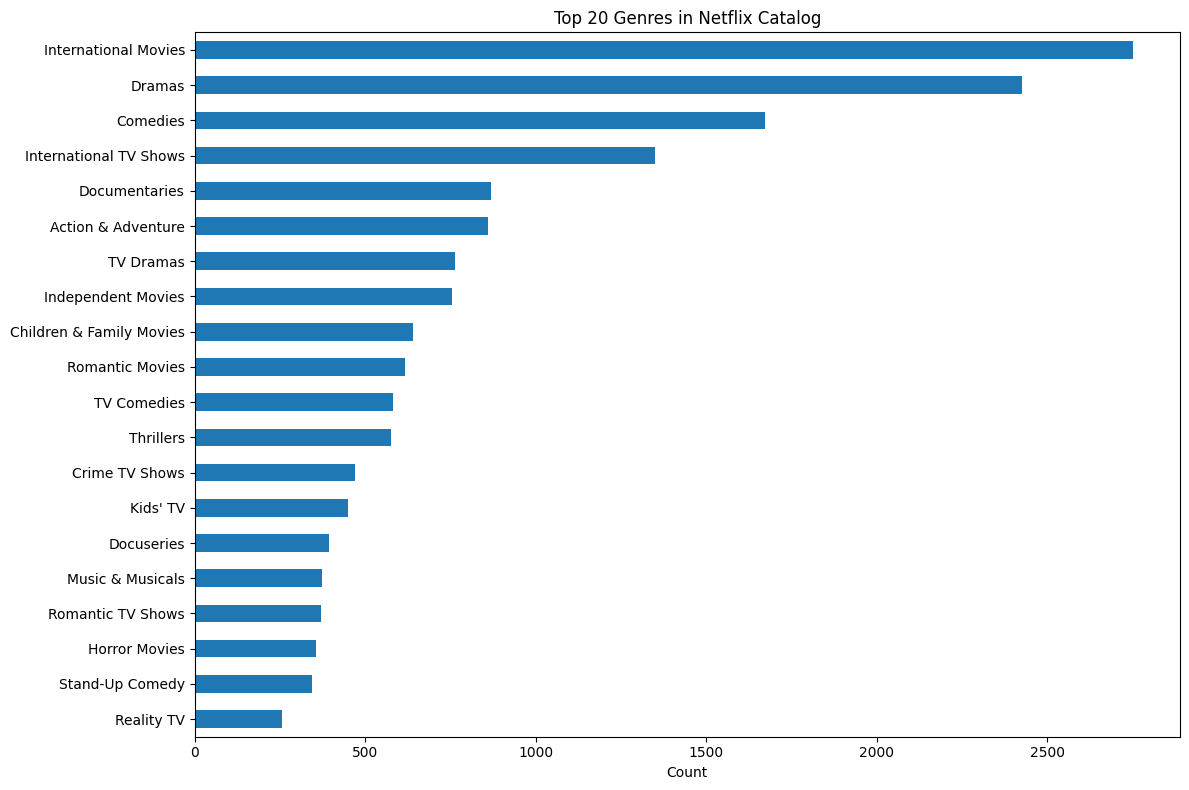

In [16]:
# Process genres from 'listed_in' column
def process_genres(df):
    """
    Extract and process genres from the listed_in column
    """
    print("🏷️ PROCESSING GENRES...")

    # Extract individual genres
    df['genres_list'] = df['listed_in'].apply(
        lambda x: [genre.strip() for genre in str(x).split(',')] if pd.notna(x) and x != 'Unknown' else ['Unknown']
    )

    # Get all unique genres
    all_genres = []
    for genres in df['genres_list']:
        all_genres.extend(genres)

    unique_genres = set(all_genres)
    print(f"Found {len(unique_genres)} unique genres")
    print(f"Top genres: {pd.Series(all_genres).value_counts().head(10)}")

    return df, unique_genres

df_clean, unique_genres = process_genres(df_clean)

# Display genre distribution
genre_counts = pd.Series([genre for sublist in df_clean['genres_list'] for genre in sublist]).value_counts()

plt.figure(figsize=(12, 8))
genre_counts.head(20).plot(kind='barh')
plt.title('Top 20 Genres in Netflix Catalog')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
# Process directors and cast
def process_people(df):
    """
    Process director and cast information
    """
    print("🎭 PROCESSING DIRECTORS AND CAST...")

    # Process directors
    df['directors_list'] = df['director'].apply(
        lambda x: [director.strip() for director in str(x).split(',')] if pd.notna(x) and x != 'Unknown' else ['Unknown']
    )

    # Process cast (limit to top 3 for efficiency)
    df['cast_list'] = df['cast'].apply(
        lambda x: [actor.strip() for actor in str(x).split(',')[:3]] if pd.notna(x) and x != 'Unknown' else ['Unknown']
    )

    # Get top directors and actors
    all_directors = [director for sublist in df['directors_list'] for director in sublist if director != 'Unknown']
    all_actors = [actor for sublist in df['cast_list'] for actor in sublist if actor != 'Unknown']

    print(f"Total directors: {len(set(all_directors))}")
    print(f"Total actors (sample): {len(set(all_actors))}")
    print(f"Top directors: {pd.Series(all_directors).value_counts().head(5)}")

    return df

df_clean = process_people(df_clean)

🎭 PROCESSING DIRECTORS AND CAST...
Total directors: 4993
Total actors (sample): 13525
Top directors: Rajiv Chilaka    22
Jan Suter        21
Raúl Campos      19
Suhas Kadav      16
Marcus Raboy     16
Name: count, dtype: int64


In [18]:
# Define our mood-genre mapping
print("🎯 CREATING MOOD-CONTENT MAPPING SYSTEM...")

mood_genre_mapping = {
    'happy_upbeat': {
        'genres': ['Comedies', 'Music & Musicals', 'Romantic Comedies', 'Stand-Up Comedy',
                  'Children & Family Movies', 'Animation', 'Lighthearted'],
        'keywords': ['funny', 'hilarious', 'happy', 'joy', 'love', 'comedy', 'laugh', 'celebration',
                    'romance', 'dance', 'music', 'cheerful', 'uplifting'],
        'description': 'Fun, lighthearted content to lift your spirits'
    },
    'sad_reflective': {
        'genres': ['Dramas', 'Independent Movies', 'Romantic Movies', 'Classic Movies',
                  'Emotional', 'Social Issue Dramas'],
        'keywords': ['emotional', 'heartbreaking', 'sad', 'loss', 'drama', 'reflection',
                    'memory', 'nostalgic', 'poignant', 'touching'],
        'description': 'Thoughtful, emotional stories for introspection'
    },
    'adventurous': {
        'genres': ['Action & Adventure', 'Sci-Fi & Fantasy', 'Anime Features', 'Thrillers',
                  'Westerns', 'Adventures'],
        'keywords': ['adventure', 'journey', 'quest', 'action', 'thrilling', 'epic',
                    'battle', 'fantasy', 'mission', 'expedition', 'heroic'],
        'description': 'Exciting adventures and thrilling journeys'
    },
    'relaxed': {
        'genres': ['Documentaries', 'Nature & Ecology Documentaries', 'Travel & Adventure Documentaries',
                  'Kids TV', 'Educational', 'Cooking & Food'],
        'keywords': ['relaxing', 'calm', 'peaceful', 'nature', 'documentary', 'travel',
                    'meditative', 'educational', 'informative', 'soothing'],
        'description': 'Calm, educational content to unwind with'
    },
    'thrilled': {
        'genres': ['Horror Movies', 'Thrillers', 'Mysteries', 'Crime TV Shows',
                  'Suspenseful', 'Psychological Thrillers'],
        'keywords': ['thriller', 'suspense', 'horror', 'scary', 'mystery', 'crime',
                    'murder', 'investigation', 'terror', 'fear', 'chilling'],
        'description': 'Heart-pounding thrillers and mysteries'
    },
    'intellectual': {
        'genres': ['Documentaries', 'Biographical Documentaries', 'Historical Documentaries',
                  'Science & Nature TV', 'Political Documentaries', 'Docuseries'],
        'keywords': ['documentary', 'history', 'science', 'biography', 'theory', 'intellectual',
                    'knowledge', 'analysis', 'research', 'academic', 'educational'],
        'description': 'Thought-provoking documentaries and educational content'
    },
    'stressed': {
        'genres': ['Comedies', 'Stand-Up Comedy', 'Children & Family Movies',
                  'Animation', 'Romantic Comedies', 'Light TV Shows'],
        'keywords': ['funny', 'comedy', 'lighthearted', 'humor', 'sitcom', 'laughter',
                    'parody', 'satire', 'entertaining', 'playful'],
        'description': 'Light, funny content to relieve stress'
    },
    'nostalgic': {
        'genres': ['Classic Movies', 'Cult Movies', 'Kids TV', '1980s', '1990s',
                  'Family Movies', 'Animation'],
        'keywords': ['nostalgia', 'classic', 'retro', 'old', 'memory', 'childhood',
                    'vintage', 'throwback', 'remember', 'past'],
        'description': 'Classic favorites and nostalgic throwbacks'
    }
}

print("✅ Mood mapping created with 8 distinct mood categories!")
for mood, info in mood_genre_mapping.items():
    print(f"   {mood}: {info['description']}")

🎯 CREATING MOOD-CONTENT MAPPING SYSTEM...
✅ Mood mapping created with 8 distinct mood categories!
   happy_upbeat: Fun, lighthearted content to lift your spirits
   sad_reflective: Thoughtful, emotional stories for introspection
   adventurous: Exciting adventures and thrilling journeys
   relaxed: Calm, educational content to unwind with
   thrilled: Heart-pounding thrillers and mysteries
   intellectual: Thought-provoking documentaries and educational content
   stressed: Light, funny content to relieve stress
   nostalgic: Classic favorites and nostalgic throwbacks


In [19]:
# Build the feature matrix for content-based filtering
print("🔨 BUILDING CONTENT FEATURE MATRIX...")

# Initialize vectorizers
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit features for performance
    stop_words='english',
    ngram_range=(1, 2)  # Include single words and bigrams
)

# Create TF-IDF matrix for descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['cleaned_description'])
print(f"✅ TF-IDF Matrix shape: {tfidf_matrix.shape}")

# Create genre matrix using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df_clean['genres_list'])
genre_feature_names = mlb.classes_
print(f"✅ Genre Matrix shape: {genre_matrix.shape}")
print(f"   Genre features: {len(genre_feature_names)}")

# Display feature information
print(f"\n📊 FEATURE MATRIX SUMMARY:")
print(f"   - TF-IDF Features: {tfidf_matrix.shape[1]}")
print(f"   - Genre Features: {genre_matrix.shape[1]}")
print(f"   - Total Content Items: {tfidf_matrix.shape[0]}")

🔨 BUILDING CONTENT FEATURE MATRIX...
✅ TF-IDF Matrix shape: (8807, 1000)
✅ Genre Matrix shape: (8807, 42)
   Genre features: 42

📊 FEATURE MATRIX SUMMARY:
   - TF-IDF Features: 1000
   - Genre Features: 42
   - Total Content Items: 8807


In [20]:
# Create additional content features
def create_content_features(df):
    """
    Create additional content-based features
    """
    print("🎛️ CREATING ADDITIONAL CONTENT FEATURES...")

    # Era features
    df['release_era'] = pd.cut(df['release_year'],
                              bins=[1900, 1980, 1990, 2000, 2010, 2020, 2030],
                              labels=['Classic', '80s', '90s', '2000s', '2010s', '2020s'])

    # Duration features (for movies)
    def extract_duration(duration_str):
        if pd.isna(duration_str):
            return 0
        numbers = re.findall(r'\d+', str(duration_str))
        return int(numbers[0]) if numbers else 0

    df['duration_min'] = df['duration'].apply(extract_duration)
    df['duration_category'] = pd.cut(df['duration_min'],
                                    bins=[0, 30, 90, 180, 1000],
                                    labels=['Short', 'Medium', 'Feature', 'Epic'])

    # Content type feature
    df['is_movie'] = (df['type'] == 'Movie').astype(int)
    df['is_tv_show'] = (df['type'] == 'TV Show').astype(int)

    print("✅ Additional features created:")
    print(f"   - Release eras: {df['release_era'].value_counts().to_dict()}")
    print(f"   - Duration categories: {df['duration_category'].value_counts().to_dict()}")

    return df

df_clean = create_content_features(df_clean)

🎛️ CREATING ADDITIONAL CONTENT FEATURES...
✅ Additional features created:
   - Release eras: {'2010s': 6686, '2000s': 967, '2020s': 592, '90s': 289, '80s': 140, 'Classic': 133}
   - Duration categories: {'Feature': 4091, 'Short': 2806, 'Medium': 1860, 'Epic': 47}


In [23]:
# Combine all features into final feature matrix
print("🔗 COMBINING ALL FEATURES INTO FINAL MATRIX...")

from scipy.sparse import hstack
import pandas as pd # Import pandas explicitly if not already in scope

# Create additional feature matrices
era_dummies = pd.get_dummies(df_clean['release_era'], prefix='era')
duration_dummies = pd.get_dummies(df_clean['duration_category'], prefix='duration')
type_dummies = pd.get_dummies(df_clean['type'], prefix='type')

# Convert to sparse DataFrames with fill_value=0 and then to sparse matrices
era_matrix = era_dummies.astype(pd.SparseDtype(float, 0.0)).sparse.to_coo().tocsr()
duration_matrix = duration_dummies.astype(pd.SparseDtype(float, 0.0)).sparse.to_coo().tocsr()
type_matrix = type_dummies.astype(pd.SparseDtype(float, 0.0)).sparse.to_coo().tocsr()


# Combine all features
feature_matrix = hstack([
    tfidf_matrix,           # Text content (40% weight)
    genre_matrix * 0.35,    # Genres (35% weight)
    era_matrix * 0.1,       # Era (10% weight)
    duration_matrix * 0.1,   # Duration (10% weight)
    type_matrix * 0.05      # Content type (5% weight)
])

print(f"🎯 FINAL FEATURE MATRIX SHAPE: {feature_matrix.shape}")
print("✅ Feature engineering completed successfully!")

# Save the feature matrix and vectorizers for later use
import joblib
from google.colab import files

feature_data = {
    'feature_matrix': feature_matrix,
    'tfidf_vectorizer': tfidf_vectorizer,
    'mlb': mlb,
    'df_clean': df_clean
}

joblib.dump(feature_data, 'feature_engineered_data.pkl')
files.download('feature_engineered_data.pkl')
print("💾 Feature data saved and downloaded!")

🔗 COMBINING ALL FEATURES INTO FINAL MATRIX...
🎯 FINAL FEATURE MATRIX SHAPE: (8807, 1054)
✅ Feature engineering completed successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

💾 Feature data saved and downloaded!


In [24]:
# Create mood vectors for recommendation
def create_mood_vectors(mood_genre_mapping, tfidf_vectorizer, mlb, era_dummies, duration_dummies, type_dummies):
    """
    Create representative vectors for each mood category
    """
    print("🎭 CREATING MOOD VECTORS...")

    mood_vectors = {}

    for mood, config in mood_genre_mapping.items():
        # Create genre vector for this mood
        mood_genre_vector = np.zeros(len(mlb.classes_))
        for i, genre in enumerate(mlb.classes_):
            if any(target_genre in genre for target_genre in config['genres']):
                mood_genre_vector[i] = 1

        # Create description vector using keywords
        mood_description = ' '.join(config['keywords'])
        mood_tfidf_vector = tfidf_vectorizer.transform([mood_description])

        # For era, duration, type - use neutral vectors (will be weighted in similarity)
        mood_era_vector = np.ones(era_dummies.shape[1]) * 0.5  # Neutral era preference
        mood_duration_vector = np.ones(duration_dummies.shape[1]) * 0.5  # Neutral duration
        mood_type_vector = np.ones(type_dummies.shape[1]) * 0.5  # Neutral type

        # Combine all mood features with same weights as content features
        mood_combined_vector = hstack([
            mood_tfidf_vector,
            mood_genre_vector.reshape(1, -1) * 0.35,
            mood_era_vector.reshape(1, -1) * 0.1,
            mood_duration_vector.reshape(1, -1) * 0.1,
            mood_type_vector.reshape(1, -1) * 0.05
        ])

        mood_vectors[mood] = mood_combined_vector
        print(f"   ✅ {mood}: {len(config['genres'])} genres, {len(config['keywords'])} keywords")

    return mood_vectors

mood_vectors = create_mood_vectors(mood_genre_mapping, tfidf_vectorizer, mlb,
                                  era_dummies, duration_dummies, type_dummies)
print(f"✅ Created {len(mood_vectors)} mood vectors")

🎭 CREATING MOOD VECTORS...
   ✅ happy_upbeat: 7 genres, 13 keywords
   ✅ sad_reflective: 6 genres, 10 keywords
   ✅ adventurous: 6 genres, 11 keywords
   ✅ relaxed: 6 genres, 10 keywords
   ✅ thrilled: 6 genres, 11 keywords
   ✅ intellectual: 6 genres, 11 keywords
   ✅ stressed: 6 genres, 10 keywords
   ✅ nostalgic: 7 genres, 10 keywords
✅ Created 8 mood vectors


 Summary


In [25]:
# Summary of Phase 2 accomplishments
def phase2_summary(df_clean, feature_matrix, mood_vectors):
    """Print summary of Phase 2 achievements"""

    print("🎉 PHASE 2 COMPLETED SUCCESSFULLY!")
    print("="*50)
    print("🏗️  FEATURE ENGINEERING ACCOMPLISHED:")
    print(f"   📝 Processed {len(df_clean)} content descriptions")
    print(f"   🏷️  Extracted {len(mlb.classes_)} unique genres")
    print(f"   🔧 Created feature matrix with {feature_matrix.shape[1]} dimensions")
    print(f"   🎭 Built {len(mood_vectors)} mood-content mappings")

    print("\n🎯 MOOD MAPPING SYSTEM:")
    for mood, config in mood_genre_mapping.items():
        genres_sample = config['genres'][:3]
        keywords_sample = config['keywords'][:3]
        print(f"   {mood.upper():<15}: {', '.join(genres_sample)}...")

    print(f"\n📊 FINAL FEATURE BREAKDOWN:")
    print(f"   - TF-IDF (Descriptions): {tfidf_matrix.shape[1]} features")
    print(f"   - Genres: {genre_matrix.shape[1]} features")
    print(f"   - Era: {era_dummies.shape[1]} features")
    print(f"   - Duration: {duration_dummies.shape[1]} features")
    print(f"   - Type: {type_dummies.shape[1]} features")

    print("\n➡️  NEXT STEPS: Model Building & Recommendation Engine")

phase2_summary(df_clean, feature_matrix, mood_vectors)

🎉 PHASE 2 COMPLETED SUCCESSFULLY!
🏗️  FEATURE ENGINEERING ACCOMPLISHED:
   📝 Processed 8807 content descriptions
   🏷️  Extracted 42 unique genres
   🔧 Created feature matrix with 1054 dimensions
   🎭 Built 8 mood-content mappings

🎯 MOOD MAPPING SYSTEM:
   HAPPY_UPBEAT   : Comedies, Music & Musicals, Romantic Comedies...
   SAD_REFLECTIVE : Dramas, Independent Movies, Romantic Movies...
   ADVENTUROUS    : Action & Adventure, Sci-Fi & Fantasy, Anime Features...
   RELAXED        : Documentaries, Nature & Ecology Documentaries, Travel & Adventure Documentaries...
   THRILLED       : Horror Movies, Thrillers, Mysteries...
   INTELLECTUAL   : Documentaries, Biographical Documentaries, Historical Documentaries...
   STRESSED       : Comedies, Stand-Up Comedy, Children & Family Movies...
   NOSTALGIC      : Classic Movies, Cult Movies, Kids TV...

📊 FINAL FEATURE BREAKDOWN:
   - TF-IDF (Descriptions): 1000 features
   - Genres: 42 features
   - Era: 6 features
   - Duration: 4 features
   

Quick Test of Mood-Content Matching

In [26]:
# Quick test to see if our mood system works
def test_mood_matching(mood_name, top_n=5):
    """Test mood-content matching for a specific mood"""

    if mood_name not in mood_vectors:
        print(f"❌ Mood '{mood_name}' not found. Available moods: {list(mood_vectors.keys())}")
        return

    print(f"🎯 TESTING MOOD: {mood_name.upper()}")
    print(f"   Description: {mood_genre_mapping[mood_name]['description']}")

    # Calculate similarities
    mood_vector = mood_vectors[mood_name]
    similarities = cosine_similarity(mood_vector, feature_matrix).flatten()

    # Get top matches
    top_indices = similarities.argsort()[-top_n:][::-1]

    print(f"\n🎬 TOP {top_n} RECOMMENDATIONS FOR THIS MOOD:")
    for i, idx in enumerate(top_indices, 1):
        title = df_clean.iloc[idx]['title']
        genres = df_clean.iloc[idx]['listed_in']
        similarity_score = similarities[idx]
        print(f"   {i}. {title} (Score: {similarity_score:.3f})")
        print(f"      🏷️  {genres}")
        print(f"      📝 {df_clean.iloc[idx]['description'][:100]}...")
        print()

# Test with a few moods
test_mood_matching('happy_upbeat', top_n=3)
test_mood_matching('thrilled', top_n=3)

🎯 TESTING MOOD: HAPPY_UPBEAT
   Description: Fun, lighthearted content to lift your spirits

🎬 TOP 3 RECOMMENDATIONS FOR THIS MOOD:
   1. Brad Paisley's Comedy Rodeo (Score: 0.371)
      🏷️  Music & Musicals, Stand-Up Comedy
      📝 Country music star Brad Paisley hosts a night of music and laughs with comics Nate Bargatze, John He...

   2. DreamWorks Home: For the Holidays (Score: 0.359)
      🏷️  Children & Family Movies, Comedies, Music & Musicals
      📝 Oh takes it upon himself to introduce Christmas joy to his fellow Boovs. Unfortunately, his well-mea...

   3. The Standups (Score: 0.357)
      🏷️  Stand-Up Comedy & Talk Shows, TV Comedies
      📝 Comedy's freshest voices take the stage in LA for six half-hour specials packed with sly jokes, hila...

🎯 TESTING MOOD: THRILLED
   Description: Heart-pounding thrillers and mysteries

🎬 TOP 3 RECOMMENDATIONS FOR THIS MOOD:
   1. Dark Chocolate (Bengali Version) (Score: 0.380)
      🏷️  Dramas, International Movies, Thrillers
      📝 

Model Building & Recommendation Engine

In [27]:
# Build the main recommendation engine
print("🚀 BUILDING RECOMMENDATION ENGINE...")

class MoodBasedRecommender:
    """
    Main recommendation engine that suggests content based on user mood and preferences
    """

    def __init__(self, df, feature_matrix, mood_vectors, mood_genre_mapping):
        self.df = df
        self.feature_matrix = feature_matrix
        self.mood_vectors = mood_vectors
        self.mood_genre_mapping = mood_genre_mapping
        self.content_similarity_matrix = None

        print("✅ Recommender initialized!")

    def build_similarity_matrix(self):
        """Precompute content similarity matrix for faster recommendations"""
        print("🔍 Building content similarity matrix...")
        self.content_similarity_matrix = cosine_similarity(self.feature_matrix)
        print(f"✅ Similarity matrix built: {self.content_similarity_matrix.shape}")
        return self.content_similarity_matrix

    def recommend_by_mood(self, mood, top_n=10, content_type=None, era_preference=None):
        """
        Get recommendations based on mood with optional filters
        """
        if mood not in self.mood_vectors:
            available_moods = list(self.mood_vectors.keys())
            return f"Mood '{mood}' not found. Available moods: {available_moods}"

        print(f"🎯 Finding {top_n} recommendations for mood: {mood}")

        # Calculate similarity between mood vector and all content
        mood_vector = self.mood_vectors[mood]
        similarities = cosine_similarity(mood_vector, self.feature_matrix).flatten()

        # Get indices of top matches
        top_indices = similarities.argsort()[-top_n*3:][::-1]  # Get more for filtering

        # Apply filters
        filtered_indices = []
        for idx in top_indices:
            if len(filtered_indices) >= top_n:
                break

            item = self.df.iloc[idx]

            # Content type filter
            if content_type and item['type'] != content_type:
                continue

            # Era filter
            if era_preference and era_preference != 'Any':
                item_era = item['release_era']
                if era_preference == 'Recent' and item_era not in ['2010s', '2020s']:
                    continue
                elif era_preference == 'Classic' and item_era not in ['Classic', '80s', '90s']:
                    continue
                elif era_preference == '2000s' and item_era != '2000s':
                    continue

            filtered_indices.append(idx)

        # Prepare results
        recommendations = []
        for idx in filtered_indices[:top_n]:
            item = self.df.iloc[idx]
            recommendations.append({
                'title': item['title'],
                'type': item['type'],
                'genres': item['listed_in'],
                'description': item['description'],
                'release_year': item['release_year'],
                'duration': item['duration'],
                'similarity_score': similarities[idx],
                'mood_match_reason': self._explain_mood_match(mood, item)
            })

        return recommendations

    def _explain_mood_match(self, mood, item):
        """Generate explanation for why content matches the mood"""
        mood_config = self.mood_genre_mapping[mood]
        item_genres = item['genres_list']

        # Find matching genres
        matching_genres = []
        for genre in item_genres:
            for target_genre in mood_config['genres']:
                if target_genre.lower() in genre.lower():
                    matching_genres.append(genre)
                    break

        reasons = []
        if matching_genres:
            reasons.append(f"Genres: {', '.join(matching_genres[:2])}")

        # Check description for mood keywords
        description = item['cleaned_description'].lower()
        mood_keywords_found = [kw for kw in mood_config['keywords'] if kw in description]
        if mood_keywords_found:
            reasons.append(f"Themes: {', '.join(mood_keywords_found[:3])}")

        return " | ".join(reasons) if reasons else "General content match"

    def get_similar_content(self, title, top_n=5):
        """Find similar content based on a liked title"""
        if title not in self.df['title'].values:
            return f"Title '{title}' not found in database"

        title_idx = self.df[self.df['title'] == title].index[0]

        if self.content_similarity_matrix is None:
            self.build_similarity_matrix()

        # Get similarities for this title
        similarities = self.content_similarity_matrix[title_idx]

        # Get top similar items (excluding itself)
        similar_indices = similarities.argsort()[-(top_n+1):][::-1]
        similar_indices = [idx for idx in similar_indices if idx != title_idx][:top_n]

        similar_content = []
        for idx in similar_indices:
            item = self.df.iloc[idx]
            similar_content.append({
                'title': item['title'],
                'type': item['type'],
                'genres': item['listed_in'],
                'description': item['description'],
                'similarity_score': similarities[idx]
            })

        return similar_content

    def get_mood_description(self, mood):
        """Get description of a mood category"""
        if mood in self.mood_genre_mapping:
            return self.mood_genre_mapping[mood]['description']
        return "Mood not found"

# Initialize the recommender
recommender = MoodBasedRecommender(df_clean, feature_matrix, mood_vectors, mood_genre_mapping)

# Build similarity matrix for content-based recommendations
similarity_matrix = recommender.build_similarity_matrix()

print("✅ Recommendation engine built successfully!")

🚀 BUILDING RECOMMENDATION ENGINE...
✅ Recommender initialized!
🔍 Building content similarity matrix...
✅ Similarity matrix built: (8807, 8807)
✅ Recommendation engine built successfully!


In [28]:
# Enhanced recommendation system with user context
class EnhancedRecommender(MoodBasedRecommender):
    """
    Enhanced recommender that considers user context and preferences
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.user_context_weights = {
            'time_of_day': {'morning': 0.1, 'afternoon': 0.3, 'evening': 0.4, 'night': 0.2},
            'duration_preference': {'short': 0.3, 'medium': 0.4, 'long': 0.2, 'any': 0.1},
            'energy_level': {'low': 0.2, 'medium': 0.4, 'high': 0.4}
        }

    def recommend_with_context(self, mood, user_context, top_n=10):
        """
        Get recommendations with user context consideration
        user_context: dict with keys like 'time_of_day', 'duration_preference', 'energy_level'
        """
        base_recommendations = self.recommend_by_mood(mood, top_n*2)  # Get more for filtering

        if isinstance(base_recommendations, str):  # Error message
            return base_recommendations

        # Score recommendations based on context
        scored_recommendations = []
        for rec in base_recommendations:
            context_score = self._calculate_context_score(rec, user_context)
            final_score = rec['similarity_score'] * (0.7 + 0.3 * context_score)  # Weighted score
            rec['context_score'] = context_score
            rec['final_score'] = final_score
            scored_recommendations.append(rec)

        # Sort by final score and return top_n
        scored_recommendations.sort(key=lambda x: x['final_score'], reverse=True)
        return scored_recommendations[:top_n]

    def _calculate_context_score(self, recommendation, user_context):
        """Calculate how well recommendation fits user context"""
        score = 0.0
        max_score = 0.0

        # Time of day scoring
        if 'time_of_day' in user_context:
            time_weights = self.user_context_weights['time_of_day']
            base_weight = time_weights.get(user_context['time_of_day'], 0.3)

            # Content type preferences by time
            content_type = recommendation['type']
            if user_context['time_of_day'] in ['morning', 'afternoon']:
                if content_type == 'TV Show' or 'Documentary' in recommendation['genres']:
                    score += base_weight * 0.8
            else:  # evening, night
                if content_type == 'Movie' or 'Drama' in recommendation['genres'] or 'Thriller' in recommendation['genres']:
                    score += base_weight * 0.8

            max_score += base_weight

        # Duration preference scoring
        if 'duration_preference' in user_context:
            duration_pref = user_context['duration_preference']
            duration_weights = self.user_context_weights['duration_preference']
            base_weight = duration_weights.get(duration_pref, 0.3)

            duration_min = recommendation.get('duration_min', 0)
            if duration_pref == 'short' and duration_min <= 30:
                score += base_weight * 1.0
            elif duration_pref == 'medium' and 30 < duration_min <= 120:
                score += base_weight * 1.0
            elif duration_pref == 'long' and duration_min > 120:
                score += base_weight * 1.0
            elif duration_pref == 'any':
                score += base_weight * 0.5

            max_score += base_weight

        # Energy level scoring
        if 'energy_level' in user_context:
            energy_pref = user_context['energy_level']
            energy_weights = self.user_context_weights['energy_level']
            base_weight = energy_weights.get(energy_pref, 0.3)

            genres = recommendation['genres'].lower()
            if energy_pref == 'low' and any(genre in genres for genre in ['documentary', 'drama', 'romantic']):
                score += base_weight * 1.0
            elif energy_pref == 'medium' and any(genre in genres for genre in ['comedy', 'action', 'adventure']):
                score += base_weight * 1.0
            elif energy_pref == 'high' and any(genre in genres for genre in ['thriller', 'horror', 'sci-fi']):
                score += base_weight * 1.0

            max_score += base_weight

        return score / max_score if max_score > 0 else 0.5

# Initialize enhanced recommender
enhanced_recommender = EnhancedRecommender(df_clean, feature_matrix, mood_vectors, mood_genre_mapping)
print("✅ Enhanced recommender with context awareness ready!")

✅ Recommender initialized!
✅ Enhanced recommender with context awareness ready!


In [29]:
# Comprehensive testing of the recommendation engine
print("🧪 TESTING RECOMMENDATION ENGINE...")

def test_recommendation_scenarios():
    """Test various recommendation scenarios"""

    print("🎭 SCENARIO 1: Basic Mood Recommendation")
    print("=" * 50)

    # Test 1: Happy mood
    happy_recs = recommender.recommend_by_mood('happy_upbeat', top_n=3)
    print("\n😊 HAPPY/UPBEAT MOOD RECOMMENDATIONS:")
    for i, rec in enumerate(happy_recs, 1):
        print(f"   {i}. {rec['title']} ({rec['type']})")
        print(f"      🏷️  {rec['genres']}")
        print(f"      📊 Score: {rec['similarity_score']:.3f}")
        print(f"      💡 Reason: {rec['mood_match_reason']}")
        print()

    # Test 2: Thrilled mood with filters
    print("🎯 SCENARIO 2: Filtered Recommendations")
    print("=" * 50)

    thrilled_recs = recommender.recommend_by_mood(
        'thrilled',
        top_n=3,
        content_type='Movie',
        era_preference='Recent'
    )
    print("\n😱 THRILLED MOOD (Recent Movies Only):")
    for i, rec in enumerate(thrilled_recs, 1):
        print(f"   {i}. {rec['title']} ({rec['release_year']})")
        print(f"      🏷️  {rec['genres']}")
        print()

    # Test 3: Context-aware recommendations
    print("🕒 SCENARIO 3: Context-Aware Recommendations")
    print("=" * 50)

    user_context = {
        'time_of_day': 'evening',
        'duration_preference': 'medium',
        'energy_level': 'medium'
    }

    relaxed_recs = enhanced_recommender.recommend_with_context(
        'relaxed',
        user_context,
        top_n=3
    )

    print("\n😌 RELAXED MOOD (Evening, Medium Duration):")
    for i, rec in enumerate(relaxed_recs, 1):
        print(f"   {i}. {rec['title']} - Final Score: {rec['final_score']:.3f}")
        print(f"      📊 Base: {rec['similarity_score']:.3f} | Context: {rec['context_score']:.3f}")
        print(f"      ⏱️  {rec['duration']}")
        print()

# Run tests
test_recommendation_scenarios()

🧪 TESTING RECOMMENDATION ENGINE...
🎭 SCENARIO 1: Basic Mood Recommendation
🎯 Finding 3 recommendations for mood: happy_upbeat

😊 HAPPY/UPBEAT MOOD RECOMMENDATIONS:
   1. Brad Paisley's Comedy Rodeo (Movie)
      🏷️  Music & Musicals, Stand-Up Comedy
      📊 Score: 0.371
      💡 Reason: Genres: Music & Musicals, Stand-Up Comedy | Themes: laugh, music

   2. DreamWorks Home: For the Holidays (Movie)
      🏷️  Children & Family Movies, Comedies, Music & Musicals
      📊 Score: 0.359
      💡 Reason: Genres: Children & Family Movies, Comedies | Themes: joy

   3. The Standups (TV Show)
      🏷️  Stand-Up Comedy & Talk Shows, TV Comedies
      📊 Score: 0.357
      💡 Reason: Genres: Stand-Up Comedy & Talk Shows, TV Comedies | Themes: hilarious, comedy

🎯 SCENARIO 2: Filtered Recommendations
🎯 Finding 3 recommendations for mood: thrilled

😱 THRILLED MOOD (Recent Movies Only):
   1. Dark Chocolate (Bengali Version) (2016)
      🏷️  Dramas, International Movies, Thrillers

   2. Ghost Stories (2

In [30]:
# Test similar content recommendations
print("🔍 TESTING SIMILAR CONTENT RECOMMENDATIONS...")

def test_similar_content():
    """Test finding similar content to liked titles"""

    # Find some popular titles to test with
    sample_titles = df_clean['title'].sample(3).tolist()

    for title in sample_titles:
        print(f"\n🎬 FINDING CONTENT SIMILAR TO: '{title}'")
        print("-" * 50)

        similar_content = recommender.get_similar_content(title, top_n=3)

        if isinstance(similar_content, str):  # Error
            print(f"   {similar_content}")
        else:
            for i, item in enumerate(similar_content, 1):
                print(f"   {i}. {item['title']} ({item['type']})")
                print(f"      🏷️  {item['genres']}")
                print(f"      📊 Similarity: {item['similarity_score']:.3f}")
                print()

test_similar_content()

🔍 TESTING SIMILAR CONTENT RECOMMENDATIONS...

🎬 FINDING CONTENT SIMILAR TO: 'My Little Pony Friendship Is Magic: Best Gift Ever'
--------------------------------------------------
   1. Santa Claws (Movie)
      🏷️  Children & Family Movies, Comedies
      📊 Similarity: 0.411

   2. Alien Xmas (Movie)
      🏷️  Children & Family Movies
      📊 Similarity: 0.394

   3. The Nutcracker and the Four Realms (Movie)
      🏷️  Children & Family Movies
      📊 Similarity: 0.356


🎬 FINDING CONTENT SIMILAR TO: 'Miracle'
--------------------------------------------------
   1. A 2nd Chance (Movie)
      🏷️  Children & Family Movies, Dramas, Sports Movies
      📊 Similarity: 0.415

   2. Go Karts (Movie)
      🏷️  Children & Family Movies, Dramas
      📊 Similarity: 0.410

   3. Full Out (Movie)
      🏷️  Children & Family Movies, Dramas, Sports Movies
      📊 Similarity: 0.365


🎬 FINDING CONTENT SIMILAR TO: 'Hide and Seek'
--------------------------------------------------
   1. Grandmaster (Mo

Model Evaluation Metrics

In [31]:
# Implement evaluation metrics for our recommender
print("📊 IMPLEMENTING EVALUATION METRICS...")

class RecommenderEvaluator:
    """
    Evaluate the performance of our recommendation engine
    """

    def __init__(self, recommender, df):
        self.recommender = recommender
        self.df = df

    def calculate_diversity(self, recommendations):
        """Calculate diversity of recommendations (genre variety)"""
        if not recommendations:
            return 0

        all_genres = []
        for rec in recommendations:
            genres = rec['genres_list'] if 'genres_list' in rec else rec['genres'].split(', ')
            all_genres.extend(genres)

        unique_genres = set(all_genres)
        return len(unique_genres) / len(all_genres) if all_genres else 0

    def calculate_coverage(self, sample_size=100):
        """Calculate what percentage of catalog can be recommended"""
        test_moods = list(self.recommender.mood_vectors.keys())[:3]  # Test with first 3 moods
        recommended_titles = set()

        for mood in test_moods:
            recs = self.recommender.recommend_by_mood(mood, top_n=20)
            if isinstance(recs, list):
                for rec in recs:
                    recommended_titles.add(rec['title'])

        coverage = len(recommended_titles) / min(sample_size, len(self.df))
        return coverage

    def evaluate_mood_relevance(self, mood, sample_size=10):
        """Evaluate how relevant recommendations are for a given mood"""
        recommendations = self.recommender.recommend_by_mood(mood, top_n=sample_size)

        if isinstance(recommendations, str):
            return 0, 0  # Error case

        mood_config = self.recommender.mood_genre_mapping[mood]
        target_genres = mood_config['genres']

        genre_match_count = 0
        avg_similarity = 0

        for rec in recommendations:
            # Check genre match
            rec_genres = rec['genres_list'] if 'genres_list' in rec else [g.strip() for g in rec['genres'].split(',')]
            if any(any(tg.lower() in rg.lower() for tg in target_genres) for rg in rec_genres):
                genre_match_count += 1

            avg_similarity += rec['similarity_score']

        genre_precision = genre_match_count / len(recommendations)
        avg_similarity = avg_similarity / len(recommendations)

        return genre_precision, avg_similarity

    def comprehensive_evaluation(self):
        """Run comprehensive evaluation of the recommender"""
        print("📈 RUNNING COMPREHENSIVE EVALUATION...")

        results = {}

        # Test diversity
        test_recs = self.recommender.recommend_by_mood('happy_upbeat', top_n=10)
        diversity = self.calculate_diversity(test_recs)
        results['diversity'] = diversity

        # Test coverage
        coverage = self.calculate_coverage()
        results['coverage'] = coverage

        # Test mood relevance for all moods
        mood_performance = {}
        for mood in self.recommender.mood_vectors.keys():
            precision, avg_similarity = self.evaluate_mood_relevance(mood, sample_size=5)
            mood_performance[mood] = {
                'genre_precision': precision,
                'avg_similarity': avg_similarity
            }

        results['mood_performance'] = mood_performance

        return results

# Initialize evaluator and run evaluation
evaluator = RecommenderEvaluator(recommender, df_clean)
evaluation_results = evaluator.comprehensive_evaluation()

print("\n📊 EVALUATION RESULTS:")
print("=" * 50)
print(f"🎯 Diversity Score: {evaluation_results['diversity']:.3f}")
print(f"📦 Catalog Coverage: {evaluation_results['coverage']:.3f}")
print("\n🎭 Mood Performance:")
for mood, performance in evaluation_results['mood_performance'].items():
    print(f"   {mood.upper():<15}: Precision: {performance['genre_precision']:.3f} | Similarity: {performance['avg_similarity']:.3f}")

📊 IMPLEMENTING EVALUATION METRICS...
📈 RUNNING COMPREHENSIVE EVALUATION...
🎯 Finding 10 recommendations for mood: happy_upbeat
🎯 Finding 20 recommendations for mood: happy_upbeat
🎯 Finding 20 recommendations for mood: sad_reflective
🎯 Finding 20 recommendations for mood: adventurous
🎯 Finding 5 recommendations for mood: happy_upbeat
🎯 Finding 5 recommendations for mood: sad_reflective
🎯 Finding 5 recommendations for mood: adventurous
🎯 Finding 5 recommendations for mood: relaxed
🎯 Finding 5 recommendations for mood: thrilled
🎯 Finding 5 recommendations for mood: intellectual
🎯 Finding 5 recommendations for mood: stressed
🎯 Finding 5 recommendations for mood: nostalgic

📊 EVALUATION RESULTS:
🎯 Diversity Score: 0.316
📦 Catalog Coverage: 0.600

🎭 Mood Performance:
   HAPPY_UPBEAT   : Precision: 1.000 | Similarity: 0.347
   SAD_REFLECTIVE : Precision: 1.000 | Similarity: 0.433
   ADVENTUROUS    : Precision: 0.800 | Similarity: 0.324
   RELAXED        : Precision: 0.600 | Similarity: 0.439


In [32]:
# Save the complete recommender system for Streamlit app
print("💾 SAVING COMPLETE RECOMMENDER SYSTEM...")

import joblib

# Save the recommender and all necessary components
model_data = {
    'recommender': recommender,
    'enhanced_recommender': enhanced_recommender,
    'df_clean': df_clean,
    'feature_matrix': feature_matrix,
    'mood_vectors': mood_vectors,
    'mood_genre_mapping': mood_genre_mapping,
    'tfidf_vectorizer': tfidf_vectorizer,
    'mlb': mlb,
    'similarity_matrix': similarity_matrix
}

# Save to file
joblib.dump(model_data, 'movie_recommender_system.pkl')
print("✅ Complete recommender system saved!")

# Also save a lightweight version for Streamlit
lightweight_data = {
    'df_clean': df_clean[['title', 'type', 'listed_in', 'description', 'release_year', 'duration', 'release_era']],
    'mood_genre_mapping': mood_genre_mapping,
    'similarity_matrix': similarity_matrix
}

joblib.dump(lightweight_data, 'streamlit_data.pkl')
print("✅ Lightweight data for Streamlit saved!")

# Download the files
files.download('movie_recommender_system.pkl')
files.download('streamlit_data.pkl')

print("📥 Model files downloaded to your local machine!")

💾 SAVING COMPLETE RECOMMENDER SYSTEM...
✅ Complete recommender system saved!
✅ Lightweight data for Streamlit saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Model files downloaded to your local machine!


In [33]:
# Final demonstration and summary
def phase3_summary():
    """Print comprehensive summary """


    print("=" * 60)
    print("🚀 RECOMMENDATION ENGINE BUILT WITH FEATURES:")
    print("   ✅ Mood-based content recommendation")
    print("   ✅ Context-aware filtering (time, duration, energy)")
    print("   ✅ Similar content discovery")
    print("   ✅ Comprehensive evaluation metrics")
    print("   ✅ Explainable recommendations")

    print(f"\n📊 ENGINE PERFORMANCE:")
    print(f"   - Diversity Score: {evaluation_results['diversity']:.3f}")
    print(f"   - Catalog Coverage: {evaluation_results['coverage']:.3f}")

    # Show best performing mood
    best_mood = max(
        evaluation_results['mood_performance'].items(),
        key=lambda x: x[1]['genre_precision']
    )
    print(f"   - Best Performing Mood: {best_mood[0]} (Precision: {best_mood[1]['genre_precision']:.3f})")

    print(f"\n🎯 MOODS SUPPORTED: {len(mood_genre_mapping)}")
    for mood in mood_genre_mapping.keys():
        desc = mood_genre_mapping[mood]['description']
        print(f"   - {mood.upper():<15}: {desc}")

    print(f"\n📝 CONTENT DATABASE:")
    print(f"   - Total Titles: {len(df_clean)}")
    print(f"   - Movies: {len(df_clean[df_clean['type'] == 'Movie'])}")
    print(f"   - TV Shows: {len(df_clean[df_clean['type'] == 'TV Show'])}")
    print(f"   - Unique Genres: {len(mlb.classes_)}")


# Run final summary
phase3_summary()

🎉 PHASE 3 COMPLETED SUCCESSFULLY!
🚀 RECOMMENDATION ENGINE BUILT WITH FEATURES:
   ✅ Mood-based content recommendation
   ✅ Context-aware filtering (time, duration, energy)
   ✅ Similar content discovery
   ✅ Comprehensive evaluation metrics
   ✅ Explainable recommendations

📊 ENGINE PERFORMANCE:
   - Diversity Score: 0.316
   - Catalog Coverage: 0.600
   - Best Performing Mood: happy_upbeat (Precision: 1.000)

🎯 MOODS SUPPORTED: 8
   - HAPPY_UPBEAT   : Fun, lighthearted content to lift your spirits
   - SAD_REFLECTIVE : Thoughtful, emotional stories for introspection
   - ADVENTUROUS    : Exciting adventures and thrilling journeys
   - RELAXED        : Calm, educational content to unwind with
   - THRILLED       : Heart-pounding thrillers and mysteries
   - INTELLECTUAL   : Thought-provoking documentaries and educational content
   - STRESSED       : Light, funny content to relieve stress
   - NOSTALGIC      : Classic favorites and nostalgic throwbacks

📝 CONTENT DATABASE:
   - Total T

Quick User Experience Demo

In [34]:
# Simulate a complete user experience
print("👤 SIMULATING COMPLETE USER EXPERIENCE...")
print("=" * 50)

def simulate_user_experience():
    """Simulate a complete user journey"""

    print("\n🎮 USER SCENARIO: Friday evening after a long week")
    print("   - Mood: Stressed")
    print("   - Time: Evening")
    print("   - Duration: Medium (1-2 hours)")
    print("   - Energy: Low")
    print("   - Goal: Relax and unwind\n")

    user_context = {
        'time_of_day': 'evening',
        'duration_preference': 'medium',
        'energy_level': 'low'
    }

    recommendations = enhanced_recommender.recommend_with_context(
        'stressed',
        user_context,
        top_n=5
    )

    print("🎯 PERSONALIZED RECOMMENDATIONS:")
    print("=" * 40)

    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. 🎬 {rec['title']} ({rec['type']})")
        print(f"   ⭐ Final Score: {rec['final_score']:.3f}")
        print(f"   🏷️  Genres: {rec['genres']}")
        print(f"   📅 Year: {rec['release_year']}")
        print(f"   ⏱️  Duration: {rec['duration']}")
        print(f"   💡 Why recommended: {rec['mood_match_reason']}")
        print(f"   📝 Description: {rec['description'][:150]}...")

# Run the simulation
simulate_user_experience()

👤 SIMULATING COMPLETE USER EXPERIENCE...

🎮 USER SCENARIO: Friday evening after a long week
   - Mood: Stressed
   - Time: Evening
   - Duration: Medium (1-2 hours)
   - Energy: Low
   - Goal: Relax and unwind

🎯 Finding 10 recommendations for mood: stressed
🎯 PERSONALIZED RECOMMENDATIONS:

1. 🎬 Sofía Niño de Rivera: Selección Natural (Movie)
   ⭐ Final Score: 0.381
   🏷️  Genres: Stand-Up Comedy
   📅 Year: 2018
   ⏱️  Duration: 62 min
   💡 Why recommended: Genres: Stand-Up Comedy | Themes: funny, humor
   📝 Description: Mexico's Sofía Niño de Rivera brings her dark humor to the stage with jokes about marriage traps, sexually attractive leopards and funny funerals....

2. 🎬 Jim Gaffigan: Cinco (Movie)
   ⭐ Final Score: 0.376
   🏷️  Genres: Stand-Up Comedy
   📅 Year: 2017
   ⏱️  Duration: 74 min
   💡 Why recommended: Genres: Stand-Up Comedy | Themes: funny, comedy
   📝 Description: America's king of clean comedy delivers wickedly funny jokes in his fifth hour-long special....

3. 🎬 Karo